# Homework Assignment4

In [195]:
import rawpy
import PIL
import scipy.sparse.linalg
import os
import glob
import numpy as np
import cv2
from PIL import Image

## LINEARIZE RENDERED IMAGES

In [196]:

img_list = [cv2.resize(cv2.imread(f'exposure_stack/exposure{idx}.jpg'), \
                       (600, 400)) for idx in range(1, 17)]
img_list_r = [img[..., 2] for img in img_list] # imgs for R-channel
img_list_g = [img[..., 1] for img in img_list] # imgs for G-channel
img_list_b = [img[..., 0] for img in img_list] # imgs for B-channel

B = np.zeros((len(img_list), 1)) # shutter speed
log_B = np.zeros((len(img_list), 1)) # log shutter speed
for i in range(len(img_list)):
    B[i] = 2**i / 2048
    log_B[i] = np.log(B[i])

In [197]:
def gsolve(Z, B, l, w):
    # Z: input image
    # B: shutter speed
    # l: smoothing lambda
    # w: weight for each pixel
    n = 256
    num_imgs, num_pixels = Z.shape
    A = np.zeros(shape=(num_pixels*num_imgs+n+1, n+num_pixels),
                 dtype=np.float32)
    b = np.zeros((A.shape[0], 1), dtype=np.float32)
    k=0
    for i in range(num_imgs):
        for j in range(num_pixels):
            zij = int(Z[i][j])
            wij = w[zij]
            A[k, zij] = wij
            A[k, n+j] = -wij
            b[k] = wij* B[i]
            k += 1

    A[k, 128] = 1
    k += 1
    
    for i in range(n-1):
        A[k, i] = l*w[i+1]
        A[k, i+1] = -2 * l * w[i+1]
        A[k, i+2] = l*w[i+1]
        k += 1

    x = np.linalg.lstsq(A,b)[0]
    g = x[:n]
    lE = x[n:]
    return g, lE

In [150]:
l = 10
w = np.ones((256,1))
img_sample_r = np.array([cv2.resize(img, (10,10)).flatten() for img in img_list_r], dtype=np.float32)
img_sample_g = np.array([cv2.resize(img, (10,10)).flatten() for img in img_list_g], dtype=np.float32)
img_sample_b = np.array([cv2.resize(img, (10,10)).flatten() for img in img_list_b], dtype=np.float32)

g_r, lE_r = gsolve(img_sample_r, log_B, l, w)
g_g, lE_g = gsolve(img_sample_g, log_B, l, w)
g_b, lE_b = gsolve(img_sample_b, log_B, l, w)



/tmp/ipykernel_36384/2755803256.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A,b)[0]


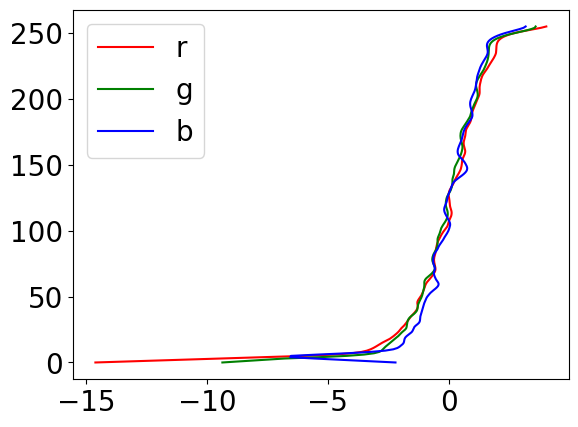

In [151]:
import matplotlib.pyplot as plt

y_value = np.arange(0, 256)

plt.plot(g_r, y_value, 'r')
plt.plot(g_g, y_value, 'g')
plt.plot(g_b, y_value, 'b')
plt.legend(['r', 'g', 'b'])

## MERGE EXPOSURE STACK INTO HDR IMAGE

In [146]:
def weight(Z_max=0.99, Z_min=0.01, max_value=255.0, scheme='uniform'):
    n = 256 # number of pixels
    w = np.zeros((n,1)) # weights for each pixel intensity.

    if scheme == 'uniform':
        for i in range(n):
            if i >= Z_min * 255.0 and i <= Z_max * 255.0:
                w[i] = 128.0
            
    elif scheme == 'tent':
        for i in range(n):
            w[i] = i if i <= 0.5*255 else 255-i
        
    elif scheme == 'gaussian':
        for i in range(n):
            w[i] = np.exp(-4 * (i/255.0 - 0.5)**2 / 0.5**2) * 255.0
    else:
        print("Choose among 'uniform', 'gaussian' and 'tent'.")
    return w

In [152]:
def compute_g_function(rgb_list, log_B, w, l=10):
    g_list = []
    for ch in range(len(rgb_list)):
        img_sample = np.array([cv2.resize(img[ch], (10,10)).flatten() for img in img_list], dtype=np.float32)
        g, _ = gsolve(img_sample, log_B, l, w)
        g_list.append(g)
    
    return g_list

def compute_hdr(raw=True, linear=True, weight_scheme='uniform', name='hdr.hdr'):
    print(f"file name : {name}, raw : {raw}, linear : {linear}, weight_scheme : {weight_scheme}")
    
    resize_h, resize_w = 400, 600 # resized scales
    if raw:
        img_list = [cv2.resize(cv2.imread(f'exposure_stack/exposure{idx}.tiff', flags=cv2.IMREAD_UNCHANGED), 
                               (resize_w, resize_h), cv2.INTER_AREA) for idx in range(1, 17)]
        img_list = [(im / (2**16-1) * 255.0).astype(np.uint8) for im in img_list] # normalize 16-bit .tiff to 8-bit
    else:
        img_list = [cv2.resize(cv2.imread(f'exposure_stack/exposure{idx}.jpg'), (resize_w, resize_h))
                    for idx in range(1, 17)]
    
    w = weight(scheme=weight_scheme) # define weighting function
    
    img_list_r = [img[..., 2] for img in img_list]
    img_list_g = [img[..., 1] for img in img_list]
    img_list_b = [img[..., 0] for img in img_list]
    
    if not raw: # define inverse g function
        # Note: the weighting scheme should be the same as the one for logarithmetic merging.
        g_list = compute_g_function([img_list_r, img_list_g, img_list_b], log_B, w)
        g_r, g_g, g_b = g_list[0], g_list[1], g_list[2]
    
    print("compute inverse function")

    sum_r = np.zeros((resize_h*resize_w, 1))
    sum_g = np.zeros((resize_h*resize_w, 1))
    sum_b = np.zeros((resize_h*resize_w, 1))

    Z_r = np.array([img.flatten() for img in img_list_r])
    Z_g = np.array([img.flatten() for img in img_list_g])
    Z_b = np.array([img.flatten() for img in img_list_b])

    tmp_hdr = np.zeros((resize_h*resize_w, 3)) # array for flattened vector
    final_hdr = np.zeros((resize_h, resize_w, 3)) # array for final hdr

    num_pixels = resize_h * resize_w

    for i in range(num_pixels):
        sum_w_r = 0
        sum_w_g = 0
        sum_w_b = 0
        for j in range(len(img_list)):
            z_r = int(Z_r[j,i])
            z_g = int(Z_g[j,i])
            z_b = int(Z_b[j,i])

            if raw:
                v_r = z_r
                v_g = z_g
                v_b = z_b
            else:
                v_r = g_r[z_r]
                v_g = g_g[z_g]
                v_b = g_b[z_b]
            if linear:
                # need to divide the values by shutter speed
                sum_r[i] += w[z_r] * v_r / B[j]
                sum_g[i] += w[z_g] * v_g / B[j]
                sum_b[i] += w[z_b] * v_b / B[j]
            else: 
                # need to subtract the logarithmatic shutter speed from the results of inverse function
                sum_r[i] += w[z_r] * (v_r - log_B[j])
                sum_g[i] += w[z_g] * (v_g - log_B[j])
                sum_b[i] += w[z_b] * (v_b - log_B[j])

            sum_w_r += w[z_r]
            sum_w_g += w[z_g]
            sum_w_b += w[z_b]

        tmp_hdr[i][2] = sum_r[i] / sum_w_r if sum_w_r > 0 else sum_r[i]
        tmp_hdr[i][1] = sum_g[i] / sum_w_g if sum_w_g > 0 else sum_g[i]
        tmp_hdr[i][0] = sum_b[i] / sum_w_b if sum_w_b > 0 else sum_b[i]
        sum_w_r = 0
        sum_w_g = 0
        sum_w_b = 0
    # reshape the flattened vector to original size
    final_hdr[..., 0] = np.reshape(tmp_hdr[:,0], (resize_h, resize_w))
    final_hdr[..., 1] = np.reshape(tmp_hdr[:,1], (resize_h, resize_w))
    final_hdr[..., 2] = np.reshape(tmp_hdr[:,2], (resize_h, resize_w))
    print("merge images")
    
    if not linear: # for logarithmatic merging, the output should be exponentialized
        final_hdr = np.exp(final_hdr)
    
    cv2.imwrite(name, final_hdr.astype(np.float32))
    print(f"{name} saved succesfully ")

In [153]:
compute_hdr(raw=False, linear=False, weight_scheme='tent', name='render_log_tent.hdr')

file name : render_log_tent.hdr, raw : False, linear : False, weight_scheme : tent


/tmp/ipykernel_36384/2755803256.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A,b)[0]


compute inverse function
merge images
render_log_tent.hdr saved succesfully 


In [154]:
compute_hdr(raw=False, linear=False, weight_scheme='gaussian', name='render_log_gaus.hdr')

file name : render_log_gaus.hdr, raw : False, linear : False, weight_scheme : gaussian


/tmp/ipykernel_36384/2755803256.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A,b)[0]


compute inverse function
merge images
render_log_gaus.hdr saved succesfully 


In [155]:
compute_hdr(raw=True, linear=False, weight_scheme='tent', name='raw_log_tent.hdr')

file name : raw_log_tent.hdr, raw : True, linear : False, weight_scheme : tent
compute inverse function
merge images
raw_log_tent.hdr saved succesfully 


In [156]:
compute_hdr(raw=True, linear=False, weight_scheme='gaussian', name='raw_log_gaus.hdr')

file name : raw_log_gaus.hdr, raw : True, linear : False, weight_scheme : gaussian
compute inverse function
merge images
raw_log_gaus.hdr saved succesfully 


In [157]:
compute_hdr(raw=True, linear=True, weight_scheme='gaussian', name='raw_linear_gaus.hdr')

file name : raw_linear_gaus.hdr, raw : True, linear : True, weight_scheme : gaussian
compute inverse function
merge images
raw_linear_gaus.hdr saved succesfully 


In [158]:
compute_hdr(raw=True, linear=True, weight_scheme='tent', name='raw_linear_tent.hdr')

file name : raw_linear_tent.hdr, raw : True, linear : True, weight_scheme : tent
compute inverse function
merge images
raw_linear_tent.hdr saved succesfully 


In [159]:
compute_hdr(raw=False, linear=True, weight_scheme='gaussian', name='render_linear_gaus.hdr')

file name : render_linear_gaus.hdr, raw : False, linear : True, weight_scheme : gaussian


/tmp/ipykernel_36384/2755803256.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A,b)[0]


compute inverse function
merge images
render_linear_gaus.hdr saved succesfully 


In [160]:
compute_hdr(raw=False, linear=True, weight_scheme='tent', name='render_linear_tent.hdr')

file name : render_linear_tent.hdr, raw : False, linear : True, weight_scheme : tent


/tmp/ipykernel_36384/2755803256.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A,b)[0]


compute inverse function
merge images
render_linear_tent.hdr saved succesfully 


## EVALUATION

In [206]:
'''
I referred the utilization code from https://web.cs.hacettepe.edu.tr/~erkut/bbm444.s22/, to implement it with python.
There is no answer code, but only including helping code in the according website.

'''

import numpy as np
import cv2

def read_colorchecker_gm():
    """Returns a 4x6 matrix with sRGB linear values of the Greatg-Macbeth color checker

    function uses L*a*b* data under D50 illumination published by Gretag-Macbeth in 2005 
    (according to http://www.babelcolor.com/main_level/ColorChecker.htm)
    data obtained from  
    Danny Pascale: "RGB coordinates of the Macbeth ColorChecker", page 6
    (available from same webpage)
    the function performs chromatic adaptation from D50 to D65 (sRGB standard illum.) and a conversion from L*a*b* to linear sRGB values

     (c) 200x - 2011; x in {9,10}, Ivo Ihrke
     Universitaet des Saarlandes / MPI Informatik

    L a* b* data CIE D50 illumination for the Gretag Macbeth color checker
    """

    L = [ \
     37.986, \
     65.711, \
     49.927, \
     43.139, \
     55.112, \
     70.719, \
     62.661, \
     40.020, \
     51.124, \
     30.325, \
     72.532, \
     71.941, \
     28.778, \
     55.261, \
     42.101, \
     81.733, \
     51.935, \
     51.038, \
     96.539, \
     81.257, \
     66.766, \
     50.867, \
     35.656, \
     20.461 ]


    a = [ \
     13.555, \
     18.130, \
     -4.880, \
    -13.095, \
      8.844, \
    -33.397, \
     36.067, \
     10.410, \
     48.239, \
     22.976, \
    -23.709, \
     19.363, \
     14.179, \
    -38.342, \
     53.378, \
      4.039, \
     49.986, \
    -28.631, \
     -0.425, \
     -0.638, \
     -0.734, \
     -0.153, \
     -0.421, \
     -0.079  ]  


    b = [ \
     14.059, \
     17.810, \
    -21.925, \
     21.905, \
    -25.399, \
     -0.199, \
     57.096, \
    -45.964, \
     16.248, \
    -21.587, \
     57.255, \
     67.857, \
    -50.297, \
     31.370, \
     28.190, \
     79.819, \
    -14.574, \
    -28.638, \
      1.186, \
     -0.335, \
     -0.504, \
     -0.270, \
     -1.231, \
     -0.973  ]

    L = np.reshape(L, (4, 6))
    a = np.reshape(a, (4, 6))
    b = np.reshape(b, (4, 6))

    Lab = np.zeros((4, 6, 3))
    Lab[:, :, 0] =  L
    Lab[:, :, 1] =  a
    Lab[:, :, 2] =  b

    # compute XYZ
    XYZ = Lab_to_XYZ(Lab, 'D50')

    # compute conversion matrices
    [ M_XYZ_to_RGB, illuminant ] = XYZ_to_RGB_linear( 'sRGB' )

    M = chromatic_adaptation_xyz ( 'D65', illuminant, 'Bradford' )

    # apply conversion matrices
    XYZ = apply_color_matrix( XYZ, M )
    RGB = apply_color_matrix( XYZ, M_XYZ_to_RGB ) # we want linear RGB values for our HDR measurements

    r = RGB[:, :, 0]
    g = RGB[:, :, 1]
    b = RGB[:, :, 2]

    return r, g, b


def chromatic_adaptation_xyz(from_illum, to_illum, method='Bradford'):

    """
    (c) Ivo Ihrke 2011
        Universitaet des Saarlandes / MPI Informatik

    computes chromatic adaptation matrix for XYZ space
    chromatic adaptation

    input: illuminant names (from, to) and method

           method = 'XYZScaling', 'Bradford', 'vonKries'

           default 'Bradford'

    implementation and choice of default according to 

    http://brucelindbloom.com/index.html?Eqn_ChromAdapt.html

    the conversion matrices given on this webpage seem to  
    use the 'XYZScaling' method which is mentioned as the
    worst choice.
    """

    fX, fY, fZ = illuminant_xyz( from_illum )

    tX, tY, tZ = illuminant_xyz( to_illum )


    # setup Ma (cone response domain transform) according to <method>

    mselected = 0

    if method == 'XYZScaling':
        Ma = np.eye(3)
        mselected = 1

    if method == 'Bradford':
        Ma = np.array([ [0.8951000,  0.2664000, -0.1614000], \
                        [-0.7502000,  1.7135000, 0.0367000], \
                        [0.0389000, -0.0685000,  1.0296000] ])
        mselected = 1


    if method == 'vonKries':
        Ma = np.array([ [0.4002400,  0.7076000, -0.0808100], \
                        [-0.2263000,  1.1653200, 0.0457000], \
                        [0.0000000,  0.0000000,  0.91822000]])
        mselected = 1

    if not mselected:
        # print('chromatic_adaptation_xyz: unknown transform - returning unit matrix');
        M = np.eye(3)
    else:
        # compute transform matrix 

        # rho, gamma, beta
        from_rgb = Ma @ np.array((fX, fY, fZ))

        to_rgb = Ma @ np.array((tX, tY, tZ))

        M = np.linalg.inv(Ma) @ np.diag(to_rgb / from_rgb) @ Ma

    return M



def Lab_to_XYZ(Lab, illuminant='D65'):
    """(c) Ivo Ihrke 2011
    Universitaet des Saarlandes / MPI Informatik

    convert from L*a*b* (CIELAB) to XYZ color space 
    using one of the CIE standard illuminants

    source:                                                                                                                                                                  
    http://en.wikipedia.org/wiki/Lab_color_space#CIE_XYZ_to_CIE_L.2Aa.2Ab.2A_.28CIELAB.29_and_CIELAB_to_CIE_XYZ_conversions
    2011-01-06

    see also:

    illuminant_xyz
    """
   
    Xn, Yn, Zn = illuminant_xyz(illuminant)

    L = Lab[:, :, 0]
    a = Lab[:, :, 1]
    b = Lab[:, :, 2]
    
    XYZ = np.zeros_like(Lab)
    XYZ[:, :, 0] = Xn * finv( 1/116 * ( L + 16 ) + 1/500 * a )
    XYZ[:, :, 1] = Yn * finv( 1/116 * ( L + 16 ) )
    XYZ[:, :, 2] = Zn * finv( 1/116 * ( L + 16 ) - 1/200 * b )

    return XYZ

def finv(val):
    val_out = np.where(val > 6/29, val**3, 3 * (6/29)**2 * ( val - 4/29 ))
    return val_out

def apply_color_matrix(I, matrix):
    """ Applies a 3x3 color matrix to a 3-channel image I

    (c) 2011 Ivo Ihrke
    Universitaet des Saarlandes 
    MPI Informatik
    """
    
    vec = np.reshape(I, (I.shape[0]*I.shape[1], 3))
    out_vec = matrix @ vec.T
    out = np.reshape(out_vec.T, (I.shape[0], I.shape[1], 3))
    return out

def XYZ_to_RGB_linear(rgb_space='sRGB'):
    """ Data from

    http://brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html

    Name             Gamma   Reference White   Red Primary            Green Primary          Blue Primary        Volume (deltaE^3)         Lab Gamut Efficiency  Coding Efficiency
                                              x      y      Y        x      y      Y        x      y      Y
    Lab Gamut          -         D50           -      -      -        -      -      -        -      -      -        2,381,085                   97.0              35.1
    Adobe RGB (1998) 2.2         D65           0.6400 0.3300 0.297361 0.2100 0.7100 0.627355 0.1500 0.0600 0.075285 1,208,631                   50.6             100.0
    Apple RGB        1.8         D65           0.6250 0.3400 0.244634 0.2800 0.5950 0.672034 0.1550 0.0700 0.083332   798,403                   33.5             100.0
    Best RGB         2.2         D50           0.7347 0.2653 0.228457 0.2150 0.7750 0.737352 0.1300 0.0350 0.034191 2,050,725                   77.6              96.5
    Beta RGB         2.2         D50           0.6888 0.3112 0.303273 0.1986 0.7551 0.663786 0.1265 0.0352 0.032941 1,717,450                   69.3              99.0
    Bruce RGB        2.2         D65           0.6400 0.3300 0.240995 0.2800 0.6500 0.683554 0.1500 0.0600 0.075452   988,939                   41.5             100.0
    CIE RGB          2.2         E             0.7350 0.2650 0.176204 0.2740 0.7170 0.812985 0.1670 0.0090 0.010811 1,725,261                   64.3              96.1
    ColorMatch RGB   1.8         D50           0.6300 0.3400 0.274884 0.2950 0.6050 0.658132 0.1500 0.0750 0.066985   836,975                   35.2             100.0
    Don RGB 4        2.2         D50           0.6960 0.3000 0.278350 0.2150 0.7650 0.687970 0.1300 0.0350 0.033680 1,802,358                   72.1              98.8
    ECI RGB v2        L*         D50           0.6700 0.3300 0.320250 0.2100 0.7100 0.602071 0.1400 0.0800 0.077679 1,331,362                   55.3              99.7
    Ekta Space PS5   2.2         D50           0.6950 0.3050 0.260629 0.2600 0.7000 0.734946 0.1100 0.0050 0.004425 1,623,899                   65.7              99.5
    NTSC RGB         2.2         C             0.6700 0.3300 0.298839 0.2100 0.7100 0.586811 0.1400 0.0800 0.114350 1,300,252                   54.2              99.9
    PAL/SECAM RGB    2.2         D65           0.6400 0.3300 0.222021 0.2900 0.6000 0.706645 0.1500 0.0600 0.071334   849,831                   35.7             100.0
    ProPhoto RGB     1.8         D50           0.7347 0.2653 0.288040 0.1596 0.8404 0.711874 0.0366 0.0001 0.000086 2,879,568                   91.2              87.3
    SMPTE-C RGB      2.2         D65           0.6300 0.3400 0.212395 0.3100 0.5950 0.701049 0.1550 0.0700 0.086556   758,857                   31.9             100.0
    sRGB            #2.2         D65           0.6400 0.3300 0.212656 0.3000 0.6000 0.715158 0.1500 0.0600 0.072186   832,870                   35.0             100.0
    Wide Gamut RGB   2.2         D50           0.7350 0.2650 0.258187 0.1150 0.8260 0.724938 0.1570 0.0180 0.016875 2,164,221                   77.6              91.9


    #2.2 - actual transform is more complex (see http://brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html )

    deltaE^3 is the volume of the gamut in Lab space
    Coding efficiency is the amount of the gamut inside the horseshoe diagram

    implementation verified with Bruce Lindbloom's data
    """

    color_spaces = [ 'Adobe RGB (1998)', 'Apple RGB', 'Best RGB', 'Beta RGB', 'Bruce RGB','CIE RGB', \
                     'ColorMatch RGB','Don RGB 4','ECI RGB v2','Ekta Space PS5','NTSC RGB','PAL/SECAM RGB','ProPhoto RGB','SMPTE-C RGB','sRGB','Wide Gamut RGB']


    reference_whites = [ 'D65', 'D65','D50','D50','D65','E','D50','D50','D50','D50','C','D65','D50','D65','D65','D50' ]

    xyY_red = np.array([[ 0.6400, 0.3300, 0.297361], \
                         [0.6250, 0.3400, 0.244634], \
                         [0.7347, 0.2653, 0.228457], \
                         [0.6888, 0.3112, 0.303273], \
                         [0.6400, 0.3300, 0.240995], \
                         [0.7350, 0.2650, 0.176204], \
                         [0.6300, 0.3400, 0.274884], \
                         [0.6960, 0.3000, 0.278350], \
                         [0.6700, 0.3300, 0.320250], \
                         [0.6950, 0.3050, 0.260629], \
                         [0.6700, 0.3300, 0.298839], \
                         [0.6400, 0.3300, 0.222021], \
                         [0.7347, 0.2653, 0.288040], \
                         [0.6300, 0.3400, 0.212395], \
                         [0.6400, 0.3300, 0.212656], \
                         [0.7350, 0.2650, 0.258187]])

    xyY_green = np.array([[0.2100, 0.7100, 0.627355], \
                          [0.2800, 0.5950, 0.672034], \
                          [0.2150, 0.7750, 0.737352], \
                          [0.1986, 0.7551, 0.663786], \
                          [0.2800, 0.6500, 0.683554], \
                          [0.2740, 0.7170, 0.812985], \
                          [0.2950, 0.6050, 0.658132], \
                          [0.2150, 0.7650, 0.687970], \
                          [0.2100, 0.7100, 0.602071], \
                          [0.2600, 0.7000, 0.734946], \
                          [0.2100, 0.7100, 0.586811], \
                          [0.2900, 0.6000, 0.706645], \
                          [0.1596, 0.8404, 0.711874], \
                          [0.3100, 0.5950, 0.701049], \
                          [0.3000, 0.6000, 0.715158], \
                          [0.1150, 0.8260, 0.724938]])

    xyY_blue = np.array([[0.1500, 0.0600, 0.075285], \
                         [0.1550, 0.0700, 0.083332], \
                         [0.1300, 0.0350, 0.034191], \
                         [0.1265, 0.0352, 0.032941], \
                         [0.1500, 0.0600, 0.075452], \
                         [0.1670, 0.0090, 0.010811], \
                         [0.1500, 0.0750, 0.066985], \
                         [0.1300, 0.0350, 0.033680], \
                         [0.1400, 0.0800, 0.077679], \
                         [0.1100, 0.0050, 0.004425], \
                         [0.1400, 0.0800, 0.114350], \
                         [0.1500, 0.0600, 0.071334], \
                         [0.0366, 0.0001, 0.000086], \
                         [0.1550, 0.0700, 0.086556], \
                         [0.1500, 0.0600, 0.072186], \
                         [0.1570, 0.0180, 0.016875 ]])


    for i in range(len(color_spaces)):
        if color_spaces[i] == rgb_space:            
            index_row = i

    Xr, Yr, Zr = xyY_to_XYZ( xyY_red[index_row, 0], xyY_red[index_row, 1], xyY_red[index_row, 2] )
    Xg, Yg, Zg = xyY_to_XYZ( xyY_green[index_row, 0], xyY_green[index_row, 1], xyY_green[index_row, 2] )
    Xb, Yb, Zb = xyY_to_XYZ( xyY_blue[index_row, 0], xyY_blue[index_row, 1], xyY_blue[index_row, 2] )


    illuminant = reference_whites[index_row]

    Xw, Yw, Zw = illuminant_xyz(illuminant)

    S = np.linalg.inv( np.array([[Xr, Xg, Xb], [Yr, Yg, Yb], [Zr, Zg, Zb]]) ) @ np.array([Xw, Yw, Zw])

    # this matrix is RGB to XYZ
    M = np.array([ [S[0]*Xr, S[1]*Xg, S[2]*Xb], [S[0]*Yr, S[1]*Yg, S[2]*Yb], [S[0]*Zr, S[1]*Zg, S[2]*Zb]])

    M = np.linalg.inv(M)

    return M, illuminant 

def illuminant_xyz(illuminant_in):
    """(c) Ivo Ihrke 2011
     Universitaet des Saarlandes / MPI Informatik

    define xyz coordinates of CIE standard illuminants
    1931 and 1964

    data from 

    http://en.wikipedia.org/wiki/Standard_illuminant



    Name    CIE 1931 2°    CIE 1964 10° CCT (*) in K    Hue Note
        x2       y2     x10     y10
    A   0.44757, 0.40745, 0.45117, 0.40594, 2856            Incandescent / Tungsten
    B   0.34842, 0.35161, 0.34980, 0.35270, 4874            {obsolete} Direct sunlightat noon
    C   0.31006, 0.31616, 0.31039, 0.31905, 6774            {obsolete} Average / North sky Daylight
    D50 0.34567, 0.35850, 0.34773, 0.35952, 5003            Horizon Light. ICC profile PCS
    D55 0.33242, 0.34743, 0.33411, 0.34877, 5503            Mid-morning / Mid-afternoon Daylight
    D65 0.31271, 0.32902, 0.31382, 0.33100, 6504            Noon Daylight: Television, sRGB color space
    D75 0.29902, 0.31485, 0.29968, 0.31740, 7504            North sky Daylight
    E   1/3    , 1/3    , 1/3    , 1/3    , 5454            Equal energy
    F1  0.31310, 0.33727, 0.31811, 0.33559, 6430            Daylight Fluorescent
    F2  0.37208, 0.37529, 0.37925, 0.36733, 4230            Cool White Fluorescent
    F3  0.40910, 0.39430, 0.41761, 0.38324, 3450            White Fluorescent
    F4  0.44018, 0.40329, 0.44920, 0.39074, 2940            Warm White Fluorescent
    F5  0.31379, 0.34531, 0.31975, 0.34246, 6350            Daylight Fluorescent
    F6  0.37790, 0.38835, 0.38660, 0.37847, 4150            Lite White Fluorescent
    F7  0.31292, 0.32933, 0.31569, 0.32960, 6500            D65 simulator, Daylight simulator
    F8  0.34588, 0.35875, 0.34902, 0.35939, 5000            D50 simulator, Sylvania F40 Design 50
    F9  0.37417, 0.37281, 0.37829, 0.37045, 4150            Cool White Deluxe Fluorescent
    F10 0.34609, 0.35986, 0.35090, 0.35444, 5000            Philips TL85, Ultralume 50
    F11 0.38052, 0.37713, 0.38541, 0.37123, 4000            Philips TL84, Ultralume 40
    F12 0.43695, 0.40441, 0.44256, 0.39717, 3000            Philips TL83, Ultralume 30

    (*) CCT= correlated color temperature


    standard is the 1931 definition

    illuinant_in = 'A','B','C', 'D50','D55','D65','D75' etc.

    for 1964 version use 

    illuinant_in = 'A_64','B_64','C_64', 'D50_64','D55_64','D65_64','D75_64' etc.


    verification performed by checking 

    http://brucelindbloom.com/index.html?Eqn_ChromAdapt.html

    """


    ind1931 = np.arange(0, 2)
    ind1964 = np.arange(2, 4)

    illuminants = [ 'A', 'B', 'C', 'D50', 'D55','D65','D75','E','F1', \
                    'F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F11']


    xy = np.array([[0.44757, 0.40745, 0.45117, 0.40594], \
          [0.34842, 0.35161, 0.34980, 0.35270], \
          [0.31006, 0.31616, 0.31039, 0.31905], \
          [0.34567, 0.35850, 0.34773, 0.35952], \
          [0.33242, 0.34743, 0.33411, 0.34877], \
          [0.31271, 0.32902, 0.31382, 0.33100], \
          [0.29902, 0.31485, 0.29968, 0.31740], \
          [1/3    , 1/3    , 1/3    , 1/3    ], \
          [0.31310, 0.33727, 0.31811, 0.33559], \
          [0.37208, 0.37529, 0.37925, 0.36733], \
          [0.40910, 0.39430, 0.41761, 0.38324], \
          [0.44018, 0.40329, 0.44920, 0.39074], \
          [0.31379, 0.34531, 0.31975, 0.34246], \
          [0.37790, 0.38835, 0.38660, 0.37847], \
          [0.31292, 0.32933, 0.31569, 0.32960], \
          [0.34588, 0.35875, 0.34902, 0.35939], \
          [0.37417, 0.37281, 0.37829, 0.37045], \
          [0.34609, 0.35986, 0.35090, 0.35444], \
          [0.38052, 0.37713, 0.38541, 0.37123], \
          [0.43695, 0.40441, 0.44256, 0.39717]])
          
    for i in range(len(illuminants)):
        if illuminants[i] == illuminant_in:
            index_row = i
            index_cols = ind1931

            if len(illuminant_in) > 3:
                if illuminant_in[-3:] == '_64':
                    index_cols = ind1964

            
            data = xy[index_row, index_cols]
            
            X, Y, Z = xyY_to_XYZ(data[0], data[1], 1)
            
    return X, Y, Z

def xyY_to_XYZ(x, y, Y):
    """(c) Ivo Ihrke 2011
    Universitaet des Saarlandes / MPI Informatik
    """

    Xo = Y * x / y
    Yo = Y
    Zo = Y * ( 1 - x - y ) / y
    return Xo, Yo, Zo



def lRGB2XYZ(lRGB):
    """ linear RGB to XYZ
    """
    invM = XYZ_to_RGB_linear('sRGB')[0]
    M = np.linalg.inv(invM)

    # linear rgb
    R = lRGB[:,:,0]
    G = lRGB[:,:,1]
    B = lRGB[:,:,2]

    # through matrix to XYZ
    X = M[0,0] * R + M[0,1] * G + M[0,2] * B
    Y = M[1,0] * R + M[1,1] * G + M[1,2] * B
    Z = M[2,0] * R + M[2,1] * G + M[2,2] * B
    
    XYZ = np.dstack((X, Y, Z))
    return XYZ

def XYZ2lRGB(XYZ):
    """ XYZ to linear RGB
    """

    invM = XYZ_to_RGB_linear('sRGB')[0]

    # XYZ
    X = XYZ[:,:,0]
    Y = XYZ[:,:,1]
    Z = XYZ[:,:,2]

    # through matrix to lRGB
    R = invM[0,0] * X + invM[0,1] * Y + invM[0,2] * Z
    G = invM[1,0] * X + invM[1,1] * Y + invM[1,2] * Z
    B = invM[2,0] * X + invM[2,1] * Y + invM[2,2] * Z

    RGB = np.dstack((R, G, B))
    return RGB

from skimage import draw

def get_mask(ys, xs, img):
    mask = poly2mask(ys, xs, img.shape[:2]).astype(int)
    fig = plt.figure()
    plt.imshow(mask, cmap='gray')
    return mask


def specify_coord(img):
    print("If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash")
    fig = plt.figure()
    plt.imshow(img, cmap='gray')
    fig.set_label('Choose target bottom-center location')
    plt.axis('off')
    clicked = []

    def on_mouse_pressed(event):
        x = int(event.xdata)
        y = int(event.ydata)
        clicked.append((x,y))
        plt.plot(x, y, 'r+')
    
    def onclose(event):
        clicked.append(xs)
        clicked.append(ys)
        
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)
    return clicked

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
img = cv2.imread("raw_linear_tent.hdr", flags=cv2.IMREAD_ANYDEPTH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


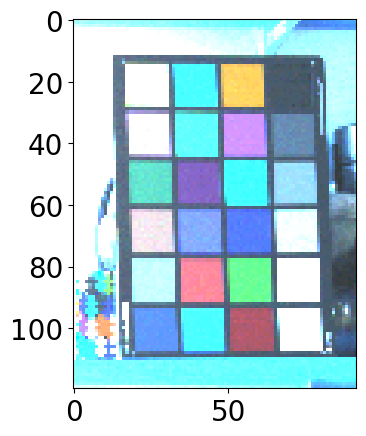

In [163]:
mask = np.load('checkerboard.npy')
mask_y, mask_x = np.where(mask == 1)
cropped_img = img[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1,:]
plt.imshow(cropped_img)

In [247]:
sq_1 = [(63, 16), (64, 28), (76, 28), (76, 16)] # coord of the darkest patch
sq_2 = [(65, 31), (65, 43), (77, 43), (76, 31)]
sq_3 = [(65, 47), (65, 58), (78, 59), (77, 46)]
sq_4 = [(66, 62), (66, 74), (78, 74), (78, 62)]
sq_5 = [(66, 77), (66, 90), (78, 90), (78, 78)]
sq_6 = [(67, 94), (67, 105), (79, 106), (78, 94)] # coord of the lightest patch 
sq_pts = [sq_1, sq_2, sq_3, sq_4, sq_5, sq_6]

def get_cropped_img(img_path):
    img = cv2.imread(img_path, flags=cv2.IMREAD_ANYDEPTH)
    np.save("checkerboard.npy", mask)
    mask_y, mask_x = np.where(mask == 1)
    cropped_img = img[min(mask_y)-1:max(mask_y)+1, min(mask_x)-1:max(mask_x)+1,:]
    return cropped_img


def get_sq_avgs(img, sq_pts):
    sq_avgs = []
    for i in range(len(sq_pts)):
        sq_region = img[sq_pts[i][0][1]:sq_pts[i][2][1], sq_pts[i][0][0]:sq_pts[i][2][0], 1] # Y channel
        sq_avgs.append(np.mean(sq_region))
    
    return sq_avgs

In [267]:
img_list = ['render_log_tent.hdr', 'render_log_gaus.hdr', 
            'raw_log_tent.hdr', 'raw_log_gaus.hdr', 
            'render_linear_tent.hdr', 'render_linear_gaus.hdr',
            'raw_linear_tent.hdr', 'raw_linear_gaus.hdr', ]

result_list = []
for img in img_list:
    sq_avgs = get_sq_avgs(get_cropped_img(img), sq_pts)
    eps = np.ones_like(sq_avgs) * 1e-6
    sq_avgs = np.log(sq_avgs + eps)
    result_list.append(sq_avgs)

/tmp/ipykernel_36384/2591740736.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = linalg.lstsq(A.T,y)[0] # obtaining the parameters


render_log_tent.hdr error : 0.05621074971161588
render_log_gaus.hdr error : 0.08403625405218004
raw_log_tent.hdr error : 0.8740514060053343
raw_log_gaus.hdr error : 0.776174225086279
render_linear_tent.hdr error : nan
render_linear_gaus.hdr error : nan
raw_linear_tent.hdr error : 0.03979517020176934
raw_linear_gaus.hdr error : 0.04036352499423958


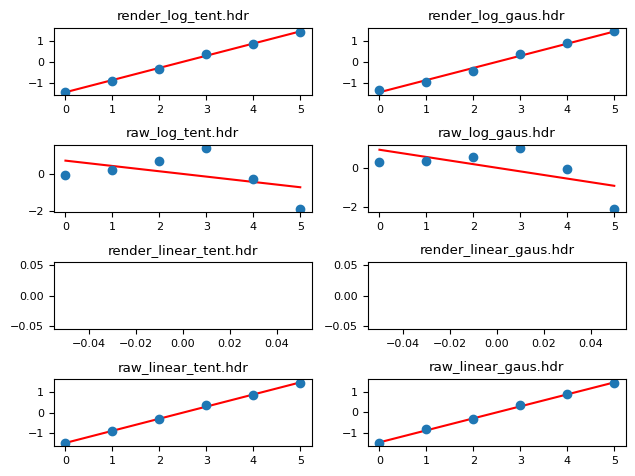

In [269]:
from numpy import arange,array,ones,linalg
# standardization the results

for i in range(len(result_list)):
    mean = np.mean(result_list[i])
    std = np.std(result_list[i])
    result_list[i] = (result_list[i] - mean) / std

error_list = []
plt.rc('font', size=8) 
for i in range(len(result_list)):
    xi = arange(0,6)
    A = array([ xi, ones(6)])
    # linearly generated sequence
    y = result_list[i]
    w = linalg.lstsq(A.T,y)[0] # obtaining the parameters

    # plotting the line
    line = w[0]*xi+w[1] # regression line
    plt.subplot(420+(i+1))
    plt.plot(xi,line,'r-',xi,y,'o')
    plt.title(img_list[i])
    
    predicted = [w[0]*x + w[1] for x in range(6)]
    error = np.sqrt(np.mean((np.array(predicted) - np.array(result_list[i])) ** 2))
    error_list.append(error)
        

plt.tight_layout()

for i in range(8):
    print(f"{img_list[i]} error : {error_list[i]}")


## PHOTOGRAPHIC TONEMAPPING

In [271]:
def tone_mapping(I, B = 0.10, K = 0.10, epsilon = 1e-6):
    I_m = np.exp(np.mean(np.log(I + epsilon))) # Eq.11
    I_tilde = K / I_m * I # Eq.10
    I_wh = B * np.max(I_tilde) # Eq.9
    I_tm = I_tilde * (1 + I_tilde / I_wh**2) / (1 + I_tilde) # Eq.8
    
    return I_tm


In [272]:
img = cv2.imread("raw_linear_tent.hdr", flags=cv2.IMREAD_ANYDEPTH)

# RGB
tm_b = tone_mapping(img[..., 0])
tm_g = tone_mapping(img[..., 1])
tm_r = tone_mapping(img[..., 2])

tm_img = np.dstack([tm_b, tm_g, tm_r])
cv2.imwrite("tm_rgb.hdr", tm_img.astype(np.float32))



True

In [273]:
def XYZ2xyY(img):
    X,Y,Z = img[...,0], img[...,1], img[...,2]
    x = X / (X+Y+Z)
    y = Y / (X+Y+Z)
    
    xyY = np.dstack([x,y,Y])
    return xyY


XYZ_img = lRGB2XYZ(img)
xyY_img = XYZ2xyY(XYZ_img)

tm_Y = tone_mapping(xyY_img[...,2])
tm_img = np.concatenate((xyY_img[...,:2], tm_Y[..., np.newaxis]), axis=2)
X,Y,Z = xyY_to_XYZ(tm_img[...,0], tm_img[...,1], tm_img[...,2])
tm_img = XYZ2lRGB(np.dstack([X,Y,Z]))

cv2.imwrite("tm_xyy.hdr", tm_img.astype(np.float32))

True

## TONEMAPPING USING BILATERAL FILTERING

In [274]:
def bilateral_tone_mapping(I, S=0.5, epsilon=1e-6):
    intensity = np.log(I+epsilon) # compute the log intensity
    base = cv2.bilateralFilter(intensity, 5, 15, 15) # Compute the base layer using bilatering filtering
    detail = intensity - base # Compute the detail layer
    base = S * (base - np.max(base)) # Apply an offset and a scale S to the base
    I_tm = np.exp(base + detail) # Reconstruct the intensity
    return I_tm

In [275]:
# RGB
b_tm_b = bilateral_tone_mapping(img[..., 0])
b_tm_g = bilateral_tone_mapping(img[..., 1])
b_tm_r = bilateral_tone_mapping(img[..., 2])

tm_img = np.dstack([b_tm_b, b_tm_g, b_tm_r])
cv2.imwrite("bilateral_tm_rgb.hdr", tm_img.astype(np.float32))

True

In [276]:
b_XYZ_img = lRGB2XYZ(img)
b_xyY_img = XYZ2xyY(b_XYZ_img)

b_tm_Y = bilateral_tone_mapping(b_xyY_img[...,2])
b_tm_img = np.concatenate((b_xyY_img[...,:2], b_tm_Y[..., np.newaxis]), axis=2)
X,Y,Z = xyY_to_XYZ(b_tm_img[...,0], b_tm_img[...,1], b_tm_img[...,2])
b_tm_img = XYZ2lRGB(np.dstack([X,Y,Z]))

cv2.imwrite("bilateral_tm_xyy.hdr", b_tm_img.astype(np.float32))

True

## IMPLEMENT A DIFFERENT GRADIENT-DOMAIN PROCESSING ALGORITHM

In [277]:
def gaussian_pyramid(img, level=1): 
    G_tensor_list = [] # length = pyramid_level + 1
    G_tensor_list.append(img)
    gauss_copy = np.ndarray(shape=img.shape, dtype='float')
    gauss_copy = img[:]
    for l in range(1, level+1):
        gauss_copy = cv2.pyrDown(gauss_copy)
        G_tensor_list.append(gauss_copy)
    
    return G_tensor_list

def compute_gradients(gauss_pyr):
    L = len(gauss_pyr) # 5 (0: finest / 4: coarsest)
    grad_atten = []
    for l in range(L):
        grad_atten.append(np.zeros_like(gauss_pyr[l]))
        
    for l in range(L-1, -1, -1):
        gradX = np.zeros(gauss_pyr[l].shape, dtype=np.float32)
        gradY = np.zeros(gauss_pyr[l].shape, dtype=np.float32)
        gradScale = 1.0 / 2**(l+1)
        
        for y in range(gauss_pyr[l].shape[0]):
            for x in range(gauss_pyr[l].shape[1]):
                ym = 0 if y == 0 else y-1
                xm = 0 if x == 0 else x-1
                yp = y if y+1 == gauss_pyr[l].shape[0] else y+1
                xp = y if x+1 == gauss_pyr[l].shape[1] else x+1
                
                gx = gauss_pyr[l][y][xm] - gauss_pyr[l][y][xp]
                gx *= gradScale
                
                gy = gauss_pyr[l][yp][x] - gauss_pyr[l][ym][x]
                gx *= gradScale
                
                gradY[y][x] = gy
                gradX[y][x] = gx
                
        magnitude = cv2.magnitude(gradX, gradY) + 1e-6
        alpha = np.mean(magnitude) * 0.1
        beta = 0.9
        phi = alpha / magnitude * (magnitude / alpha) ** beta
        
        if l == L-1:
            grad_atten[l] = phi
        else:
            size = (grad_atten[l].shape[1], grad_atten[l].shape[0])
            up_img = cv2.pyrUp(grad_atten[l+1], dstsize=size)
            
            grad_atten[l] = up_img * phi
    
    
    return grad_atten
            
def gradient_tone_mapping(img, m_grad_atten):
    gradX = np.zeros_like(img)
    gradY = np.zeros_like(img)
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            yp1 = img.shape[0] - 2 if y+1 >= img.shape[0] else y+1
            xp1 = img.shape[1] - 2 if x+1 >= img.shape[1] else x+1
            
            gradX[y][x] = img[y][xp1] - img[y][x] * 0.5 * m_grad_atten[y][xp1] + m_grad_atten[y][x]
            gradY[y][x] = img[yp1][x] - img[y][x] * 0.5 * m_grad_atten[yp1][x] + m_grad_atten[y][x]
            
            
    div_G = np.zeros_like(img)
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            div_G[y][x] = gradX[y][x] + gradY[y][x]
            if x > 0:
                div_G[y][x] -= gradX[y][x-1]
            if y > 0:
                div_G[y][x] -= gradY[y-1][x]
            
            if x == 0:
                div_G[y][x] += gradX[y][x]
            if y == 0:
                div_G[y][x] += gradY[y][x]
            
            
    return div_G
            
        
                
                

In [278]:
g_XYZ_img = lRGB2XYZ(img)
g_xyY_img = XYZ2xyY(g_XYZ_img)

Y = g_xyY_img[...,2]
log_Y = np.log(Y)

gauss_Y = gaussian_pyramid(log_Y, 4)

grad_atten = compute_gradients(gauss_Y)

m_atten_map = np.copy(grad_atten[0])

div_G = gradient_tone_mapping(log_Y, m_atten_map)

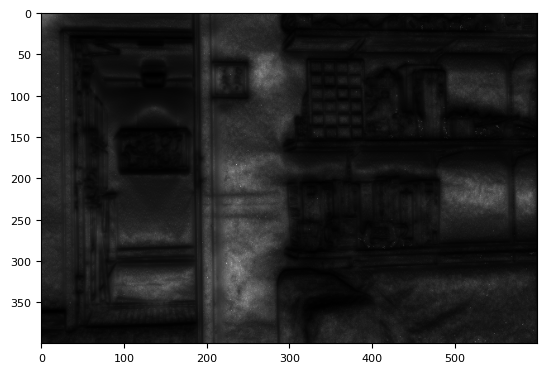

In [279]:
plt.imshow(m_atten_map, cmap='gray')

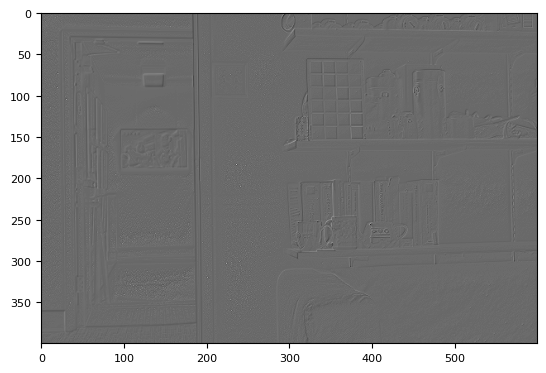

In [280]:
plt.imshow(div_G, cmap='gray')

Boundary search time = 0.0030
System matrix and right hand vector computation time = 10.523
spsolve() time = 5.1491


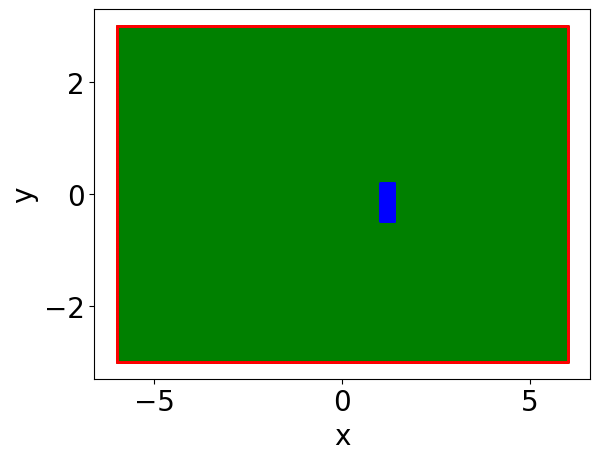

In [281]:
'''

code reference: https://github.com/zaman13/Poisson-solver-2D

'''


def Diff_mat_1D(Nx):
    
    # First derivative
    D_1d = sp.diags([-1, 1], [-1, 1], shape = (Nx,Nx)) # A division by (2*dx) is required later.
    D_1d = sp.lil_matrix(D_1d)
    D_1d[0,[0,1,2]] = [-3, 4, -1]               # this is 2nd order forward difference (2*dx division is required)
    D_1d[Nx-1,[Nx-3, Nx-2, Nx-1]] = [1, -4, 3]  # this is 2nd order backward difference (2*dx division is required)
    
    # Second derivative
    D2_1d =  sp.diags([1, -2, 1], [-1,0,1], shape = (Nx, Nx)) # division by dx^2 required
    D2_1d = sp.lil_matrix(D2_1d)                  
    D2_1d[0,[0,1,2,3]] = [2, -5, 4, -1]                    # this is 2nd order forward difference. division by dx^2 required. 
    D2_1d[Nx-1,[Nx-4, Nx-3, Nx-2, Nx-1]] = [-1, 4, -5, 2]  # this is 2nd order backward difference. division by dx^2 required.
    
    return D_1d, D2_1d




def Diff_mat_2D(Nx,Ny):
    # 1D differentiation matrices
    Dx_1d, D2x_1d = Diff_mat_1D(Nx)
    Dy_1d, D2y_1d = Diff_mat_1D(Ny)


    # Sparse identity matrices
    Ix = sp.eye(Nx)
    Iy = sp.eye(Ny)


    
    # 2D matrix operators from 1D operators using kronecker product
    # First partial derivatives
    Dx_2d = sp.kron(Iy,Dx_1d)
    Dy_2d = sp.kron(Dy_1d,Ix)
    
    # Second partial derivatives
    D2x_2d = sp.kron(Iy,D2x_1d)
    D2y_2d = sp.kron(D2y_1d,Ix)
    
   
    
    # Return compressed Sparse Row format of the sparse matrices
    return Dx_2d.tocsr(), Dy_2d.tocsr(), D2x_2d.tocsr(), D2y_2d.tocsr()


from __future__ import print_function    

import time
import math
import numpy as np
import pylab as py
import scipy.sparse as sp                 # import sparse matrix library
from scipy.sparse.linalg import spsolve

py.rcParams.update({'font.size': 20})



# Defining custom plotting functions
def my_contourf(x,y,F,ttl):
    cnt = py.contourf(x,y,F,41,cmap = 'inferno')
    py.colorbar()
    py.xlabel('x'); py.ylabel('y'); py.title(ttl)
    return 0
    

def my_scatter(x,y,clr,ttl):
    py.plot(x,y,'.',markersize=2,color=clr)
    py.xlabel('x'); py.ylabel('y'); py.title(ttl)
    return 0
    


#==============================================================================
# Dirichlet/Neumann boundary conditions at outerwalls (boundary condition type is defined through boundary operators)
uL = 0
uR = 0
uT = 0
uB = 0
#==============================================================================



#==============================================================================
# Dirichlet boundary conditions at an inner rectangular region
ub2 = 1.5             # boundary value
 
xb2 = [1, 1.4]        # lower and upper limits of x defining the inner boundary region
yb2 = [-.5,.2]        # lower and upper limits of y defining the inner boundary region
#==============================================================================



#==============================================================================
# Define independent variables
Nx = 600                        # No. of grid points along x direction
Ny = 400                         # No. of grid points along y direction
x = np.linspace(-6,6,Nx)        # x variables in 1D
y = np.linspace(-3,3,Ny)        # y variable in 1D
#==============================================================================

#//////////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////////

#==============================================================================


dx = x[1] - x[0]                # grid spacing along x direction
dy = y[1] - y[0]                # grid spacing along y direction

X,Y = np.meshgrid(x,y)          # 2D meshgrid

# 1D indexing
Xu = X.ravel()                  # Unravel 2D meshgrid to 1D array
Yu = Y.ravel()


# Source function (right hand side vector)
g = div_G.flatten() #np.zeros(Nx*Ny) 


 

# Loading finite difference matrix operators

Dx_2d, Dy_2d, D2x_2d, D2y_2d = Diff_mat_2D(Nx,Ny)   # Calling 2D matrix operators from funciton



#//////////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////////


#==============================================================================
# Boundary indices
start_time = time.time()
ind_unravel_L = np.squeeze(np.where(Xu==x[0]))          # Left boundary
ind_unravel_R = np.squeeze(np.where(Xu==x[Nx-1]))       # Right boundary
ind_unravel_B = np.squeeze(np.where(Yu==y[0]))          # Bottom boundary
ind_unravel_T = np.squeeze(np.where(Yu==y[Ny-1]))       # Top boundary

ind_boundary_unravel = np.squeeze(np.where((Xu==x[0]) | (Xu==x[Nx-1]) | (Yu==y[0]) | (Yu==y[Ny-1])))  # outer boundaries 1D unravel indices
ind_boundary = np.where((X==x[0]) | (X==x[Nx-1]) | (Y==y[0]) | (Y==y[Ny-1]))    # outer boundary


ind_boundary2_unravel = np.squeeze(np.where((Xu>xb2[0]) & (Xu<xb2[1]) & (Yu>yb2[0]) & (Yu<yb2[1])))  # inner boundaries defined by xb2 and yb2
ind_boundary2 = np.where((X>xb2[0]) & (X<xb2[1]) & (Y>yb2[0]) & (Y<yb2[1]))    #  inner boundaries


print("Boundary search time = %1.6s" % (time.time()-start_time))

# Plot solution domain (with boundary)

py.close('all')
my_scatter(X,Y,'g','Solution grid')
my_scatter(X[ind_boundary], Y[ind_boundary],'r','Solutiohn grid with boundary')
my_scatter(X[ind_boundary2], Y[ind_boundary2],'b','')
#==============================================================================

#//////////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////////


#==============================================================================
# Construction of the system matrix
start_time = time.time()
I_sp = sp.eye(Nx*Ny).tocsr()
L_sys = D2x_2d/dx**2 + D2y_2d/dy**2     # system matrix without boundary conditions

# Boundary operators
BD = I_sp       # Dirichlet boundary operator
BNx = Dx_2d     # Neumann boundary operator for x component
BNy = Dy_2d     # Neumann boundary operator for y component

# Selectively replace the rows of the system matrix that correspond to boundary value points. We replace these rows with 
# those of the boundary operator

# L_sys[ind_boundary_unravel,:] = BD[ind_boundary_unravel,:]    # Boundaries at the four edges

L_sys[ind_boundary2_unravel,:] = BD[ind_boundary2_unravel,:]  # Boundaries defined by xb2 and yb2 (inside boundaries)
L_sys[ind_unravel_T,:] = BNy[ind_unravel_T,:]    # Boundaries at the top layer
L_sys[ind_unravel_B,:] = BD[ind_unravel_B,:]    # Boundaries at the bottom layer
L_sys[ind_unravel_L,:] = BNx[ind_unravel_L,:]    # Boundaries at the left layer
L_sys[ind_unravel_R,:] = BNx[ind_unravel_R,:]    # Boundaries at the right edges

#==============================================================================

#//////////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////////
#//////////////////////////////////////////////////////////////////////////////


#==============================================================================
# Construction of right hand vector (function of x and y)
b = g
# Insert boundary values at the boundary points
b[ind_unravel_L] = uL
b[ind_unravel_R] = uR
b[ind_unravel_T] = uT
b[ind_unravel_B] = uB

b[ind_boundary2_unravel] = ub2
#==============================================================================


print("System matrix and right hand vector computation time = %1.6s" % (time.time()-start_time)) 



#==============================================================================
# solve
start_time = time.time()
u = spsolve(L_sys,b).reshape(Ny,Nx)
print("spsolve() time = %1.6s" % (time.time()-start_time))

In [282]:
g_tm_img = XYZ2lRGB(np.dstack([g_xyY_img[..., :2], u]))

cv2.imwrite("gradient_tm.hdr", g_tm_img.astype(np.float32))

True